In [1]:
%pylab inline --no-import-all
import matplotlib.ticker as ticker
import matplotlib.cm as cmap

import math
import numpy as np
import scipy.special as ssp
import scipy.stats as ss

from iminuit import Minuit

import sys
sys.path.append("/usr/local/Cellar/root/6.12.04_1/lib/root/")
sys.path.append("/Library/Python/2.7/site-packages/")

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

import george

Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.12/04


/usr/local/Cellar/python/2.7.14_3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


### the kernel, or covariance structure, is what defines a Gaussian Process. 
#### Initially, you'll start with a Exponential Squared kernel with a mean of a standard fit function used for the analysis. Having a mean function means you're modeling the fluctuations of your data around the fit function. The Gaussian Process is still flexible enough to fit the data even if the fit function doesn't fit the data well - i.e. you shouldn't need to spend time testing out different fit functions. As long as it describes the data fairly well, it should work. 
#### The exponential squared kernel is a fairly basic kernel that says the covariance between points should die off as 1/(x1-x2)^2. Most kernels you'll want for your analysis will have this feature - the farther points are away from each other, the less they effect each other. 
#### the hyperparameters of the kernel let you fine tune your kernel. For instance, the exponential squared kernel has a length scale hyperparameter l, which is related to the smoothness of your kernel. Too small, and the GP will be allowed to fluctuate on short length scales. Too large, and you smear out features you want to fit.
#### we'll also use a mean function - in our case, we're just the 3 parameter dijet function to model this fake dijet dataset

### Your mean function and kernel function are defined in meanAndKernel.py. This makes it easy to switch functions and run the entire tutorial again

In [2]:
from meanAndKernel import Mean, Kernel

# Basics fits
#### Fit GP to data or MC template

### Some useful functions

#### Calculate the z-val and chi squared fit between data and fit. The signficance is plotted in the bottom panel of makePrettyPlots

In [3]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### Make a pretty plot of fit overlaid on data in the top panel and the signficance plotted in the bottom panel

In [4]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e6):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.1, ymax])
  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(binedges,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  
    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



#### grab your data or MC from root file and save points in arrays to be used in GP fit

In [5]:
ycounts = np.load("inputs/ycounts.npy")
yerrs = np.load("inputs/yerrs.npy")

xbins = np.load("inputs/xbins.npy")
xerrs = np.load("inputs/xerrs.npy")
binedges = list(np.load("inputs/binedges.npy"))

### To fit Gaussian Process, set up a negative log likelihood minimization 

### Minimize using minuit

#### Use the built in method from george to get the log likelihood. Create a loglikelihood class to pass to minuit.  Instead of a separate prior, I'm just putting bounds on parameters in minuit. 
#### A more robust way of running minuit is to run the minimization multiple times and keep track of the lowest log likelihood value and its corresponding parameters, in case minuit settles into some local minima. You can of course just run it once, and it will mostly produce good results, and speed things up signficantly. 
#### Names of the input parameters in minuit must be the same as in the likelihood class. Set up the intial parameters, step sizes for each parameter (error), and bounds on the parameters (limit).  

In [6]:
class logLike_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, lengthscale, p0, p1, p2):
        gp = george.GP(Kernel((Amp, lengthscale)), mean=Mean((p0,p1,p2)), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return 0


        
def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, lengthscale = init1, 
                   p0 = init2, p1 = init3, p2 = init4,
                   error_Amp = 1e1, error_lengthscale = 1e1,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (0.01, 1e10), limit_lengthscale = (100, 1e6), 
                   limit_p0 = (0,10), limit_p1 = (-20, 20), limit_p2 = (-20,20)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

#### To start with george, you must always intialize a george.GP object with a kernel. You can also add in a mean function as we've done here, but if one is not specified its set to 0. You can find more inforamtion about the different pre-made kernels, options for the GP object, mean functions, and how to build your own kernel at http://dan.iel.fm/george/current/.
#### In our case, we want to use a fit function as our mean (otherwise the GP will be modeling fluctuations around 0!). We're using the 3 parameter dijet fit function. We also set the arguement fit_mean = True so that the mean function parameters will also be fit, along with the kernel hyperparameters
#### Finally, you must always call gp.compute to precompute the covariance matrix at the independent coordinates before calling most other methods

In [7]:
p_init = [5, 1e3, 1e-1, 5, -5]
Amp, lengthscale, p0, p1, p2 = p_init

In [8]:
kernel = Kernel((Amp, lengthscale))
gp = george.GP(kernel, mean=Mean((p0,p1,p2)), fit_mean = True)
gp.compute(xbins, yerrs)

#### Call your minuit minimzation

In [9]:
lnProb = logLike_minuit(xbins, ycounts, xerrs)
min_likelihood, best_fit_gp = fit_gp_minuit(100, lnProb)
Amp, lengthscale, p0, p1, p2 = best_fit_gp

np.save("inputs/fixedHyperparameters.npy",best_fit_gp)

min LL 335.047447199
best fit vals (3.170277040056451, 724898.8619785518, 0.033337705430392384, 7.97138405265504, -5.281920569537357)


#### Finally, call predict to get the mean and variance of the predictive distribution. This is what we use as our GP fit. 

In [10]:
Amp, lengthscale, p0, p1, p2 = best_fit_gp
kernel = Kernel((Amp, lengthscale))
gp = george.GP(Kernel((Amp, lengthscale)), mean=Mean((p0,p1,p2)), fit_mean = True)
gp.compute(xbins, yerrs)

MAP_GP, cov_GP = gp.predict(ycounts, xbins)

#### And make the pretty plot

chi2 2074.369095767983


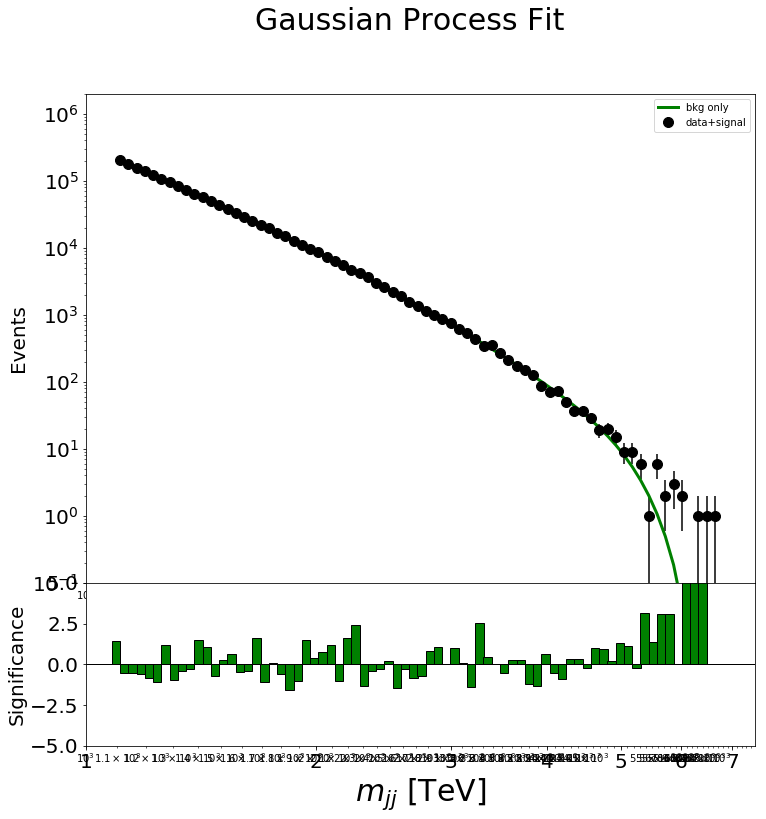

In [11]:
makePrettyPlots(xbins, ycounts, MAP_GP, "Gaussian Process Fit")

### Lets look at some samples from the posterior

#### First, something to make the plot look pretty and plot all those samples

In [12]:
def makePrettyPlots_samples(xs, ys, bkgFits, title, ymax = 1e6):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(10,7))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="Posterior samples")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.1, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

#### sample_conditional samples the predictive distribution (the same as the mean from above), where the 3rd arguement is the number of samples you want

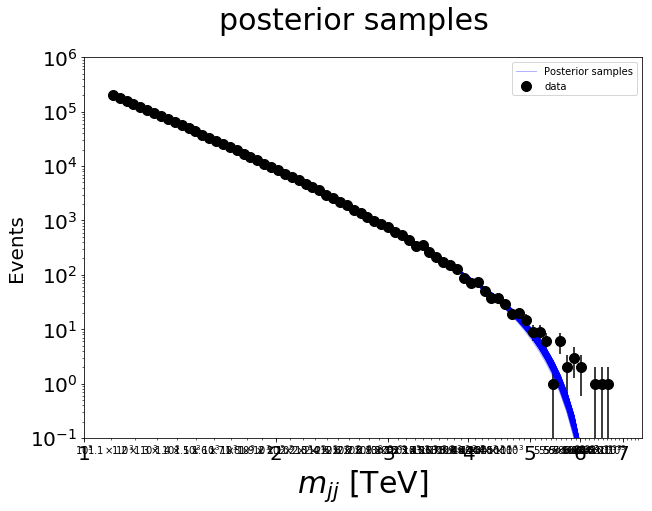

In [13]:
samps = gp.sample_conditional(ycounts, xbins, 1000)
makePrettyPlots_samples(xbins, ycounts, samps, "posterior samples")

### Check pulls of samples from posterior

In [14]:
def draw_pulls(pulls):
    plt.figure()
    bins=np.linspace(-2,2,50)

    pull_mean = np.mean(pulls)
    pull_std = np.std(pulls)

    n,_,_=plt.hist(pulls, bins=bins, normed=True)
    plt.plot(bins, ss.norm.pdf(bins, pull_mean, pull_std), c='black', linewidth='3', label="N({:.1f}, {:.1f})".format(pull_mean, pull_std))
    plt.plot(bins, ss.norm.pdf(bins, 0,1), c='r', linewidth='3', label="N(0,1)")
    print(pull_mean, pull_std)

    plt.xlabel("(GP-Smeared)/GP Uncertainty", fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.legend()
    


(0.043319746357535556, 0.9709827342827951)


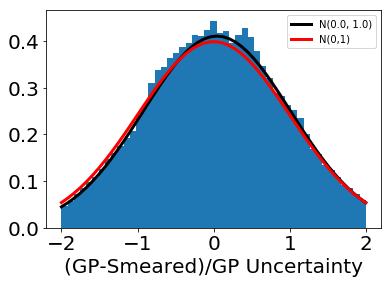

In [15]:
pull=[]
for s in samps:
    pull+=list((s-MAP_GP)/np.sqrt(np.diag(cov_GP)))
draw_pulls(pull)    